In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import matplotlib.image as img
import seaborn as sns

In [ ]:
data = pd.read_csv('creditcard.csv')

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.columns = map(str.lower, data.columns)
data.rename(columns={'class': 'label'}, inplace=True)
#data['amount'] = data['amount'].apply(lambda x: np.log10(x + 0.00001))

In [ ]:
data.isnull().sum()

,0
time,0
v1,0
v2,0
v3,0
v4,0
v5,0
v6,0
v7,0
v8,0
v9,0


In [ ]:
print(len(data[data['label'] == 1]))
print(len(data[data['label'] == 0]))

492
284315


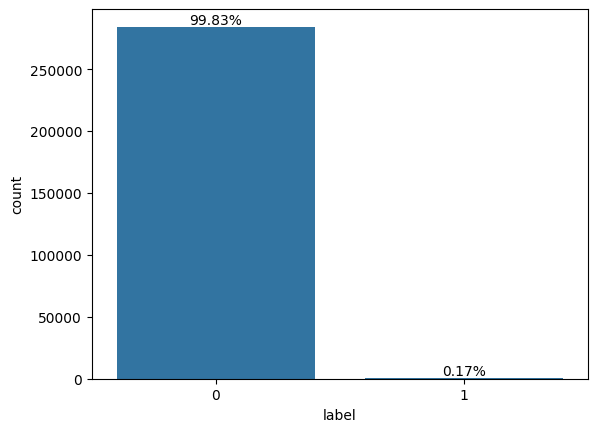

In [ ]:
ax = sns.countplot(x='label', data=data)
total = float(len(data))

for p in ax.patches:
    percentage="{:.2f}%".format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha="center", va='bottom')
plt.show()

In [ ]:
# Manual parameter
RATIO = 4
RANDOM_SEED = 42

fraud = data[data['label'] == 1]
sampling_size = int(len(fraud) * RATIO)

non_fraud = data[data['label'] == 0].sample(n=sampling_size, random_state=RANDOM_SEED)
df = pd.concat([fraud, non_fraud]).sample(frac=1).reset_index(drop=True)
X = df.drop(['label'], axis = 1).values
y = df["label"].values

In [ ]:
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,93879.0,-13.086519,7.352148,-18.256576,10.648505,-11.731476,-3.659167,-14.873658,8.810473,-5.418204,...,2.761157,-0.266162,-0.412861,0.519952,-0.743909,-0.167808,-2.498300,-0.711066,30.31,1
1,134763.0,1.843102,-1.591637,-0.242361,-0.394382,-1.497659,0.472285,-1.701736,0.271383,1.136590,...,0.335218,0.979908,0.013635,0.438696,-0.299637,-0.057407,0.064109,0.022159,142.19,0
2,55186.0,1.261295,0.345523,0.338295,0.986909,-0.145704,-0.607791,0.108546,-0.147256,0.064588,...,-0.261043,-0.754146,0.038616,-0.162365,0.437841,-0.599895,0.024282,0.025098,4.99,0
3,74226.0,-1.008092,-0.206234,1.801338,-1.302352,-1.572446,-0.201044,-0.180712,0.461341,-0.749113,...,0.241064,0.454459,0.212128,0.409589,-0.082040,-0.438991,-0.016058,0.067793,140.00,0
4,77627.0,-7.139060,2.773082,-6.757845,4.446456,-5.464428,-1.713401,-6.485365,3.409395,-3.053493,...,1.303250,-0.016118,-0.876670,0.382230,-1.054624,-0.614606,-0.766848,0.409424,106.90,1


In [ ]:
def tsne_plot(X, y, name, title='TSNE plot of Fraud and Non Fraud'):
  tsne = TSNE(n_components=2, random_state=24, init='random', learning_rate=200)
  X_t = tsne.fit_transform(X)

  plt.figure(figsize=(12,8))
  plt.scatter(X_t[np.where(y==0), 0], X_t[np.where(y==0), 1], color='red', alpha = 0.7, label = "Non Fraud")
  plt.scatter(X_t[np.where(y==1), 0], X_t[np.where(y==1), 1], color='green', alpha = 0.7, label = "Fraud")

  plt.legend(loc='best')
  plt.title(title, fontsize=16)
  plt.savefig(name)
  plt.show()

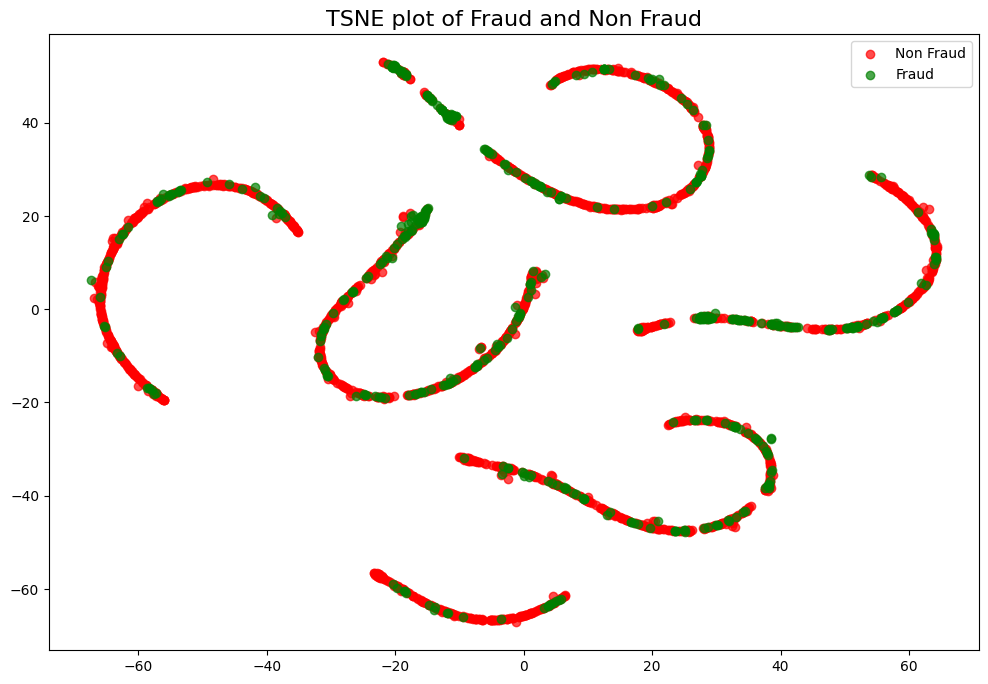

In [ ]:
tsne_plot(X, y, name="original.png")

In [ ]:
data["time"] = data["time"].apply(lambda x : x / 3600 % 24)

# Scale 'time' and 'amount'
data['amount'] = StandardScaler().fit_transform(data['amount'].values.reshape(-1, 1))
data['time'] = StandardScaler().fit_transform(data['time'].values.reshape(-1, 1))

# Separate fraudulent transactions from normal transactions
non_fraud_data, fraud_data = data[data['label']==0], data[data['label']==1]

#
train_data = non_fraud_data.iloc[:2000, :]
val_data = pd.concat([non_fraud_data.iloc[2000:2558,:], fraud_data.iloc[:442, :]], axis =0).sample(frac=1).reset_index(drop=True)
test_samples = pd.concat([non_fraud_data.iloc[2558:2608,:], fraud_data.iloc[442:,:]], axis=0).sample(frac=1).reset_index(drop=True)

In [ ]:
# These hyperparameters will be logged
hyper_params = {
    "learning_rate": 1e-1/10,
    "epochs": 150,
    "batch_size": 32,
    "weight_decay": 1e-8,
    'threshold': 0.75
}

In [ ]:
# Create pytorch data loader for training set
train_target = torch.tensor(train_data['label'].values.astype(np.float32))
train = torch.tensor(train_data.drop('label', axis = 1).values.astype(np.float32))
train_tensor = data_utils.TensorDataset(train, train_target)
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = hyper_params['batch_size'], shuffle = True)

# Create pytorch data loader for validation set
val_target = torch.tensor(val_data['label'].values.astype(np.float32))
val = torch.tensor(val_data.drop('label', axis = 1).values.astype(np.float32))
val_tensor = data_utils.TensorDataset(val, val_target)
val_loader = data_utils.DataLoader(dataset = val_tensor, batch_size = 1, shuffle = True)

In [ ]:
# Output the shapes for verification
print("Input training set shape:", train.shape)
print("Output training set shape:", train_target.shape)
print("Input validation set shape:", val.shape)
print("Output validation set shape:", val_target.shape)

Input training set shape: torch.Size([2000, 30])
Output training set shape: torch.Size([2000])
Input validation set shape: torch.Size([1000, 30])
Output validation set shape: torch.Size([1000])


In [ ]:
train_loader.dataset[0]

(tensor([-2.4864, -1.3598, -0.0728,  2.5363,  1.3782, -0.3383,  0.4624,  0.2396,
          0.0987,  0.3638,  0.0908, -0.5516, -0.6178, -0.9914, -0.3112,  1.4682,
         -0.4704,  0.2080,  0.0258,  0.4040,  0.2514, -0.0183,  0.2778, -0.1105,
          0.0669,  0.1285, -0.1891,  0.1336, -0.0211,  0.2450]),
 tensor(0.))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim, h_activ, out_activ):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, encoding_dim)
        self.h_activ, self.out_activ = h_activ, out_activ

    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        x = self.h_activ(h_n[-1])
        return self.out_activ(self.fc(x))

class Decoder(nn.Module):
    def __init__(self, encoding_dim, output_dim, hidden_dim, h_activ):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(encoding_dim, hidden_dim)
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=output_dim,
            num_layers=1,
            batch_first=True
        )
        self.h_activ = h_activ

    def forward(self, x, seq_len):
        x = self.h_activ(self.fc(x))
        x = x.repeat(seq_len, 1).unsqueeze(0)
        x, (h_n, c_n) = self.lstm(x)
        return x.squeeze(0)

class LSTM_AE(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim, h_activ=nn.ReLU(), out_activ=nn.Tanh()):
        super(LSTM_AE, self).__init__()
        self.encoder = Encoder(input_dim, encoding_dim, hidden_dim, h_activ, out_activ)
        self.decoder = Decoder(encoding_dim, input_dim, hidden_dim, h_activ)

    def forward(self, x):
        seq_len = x.shape[1]  # sequence length (30 in your case)
        x = self.encoder(x)
        x = self.decoder(x, seq_len)
        return x

# Example training loop (simplified)
model = LSTM_AE(input_dim=30, encoding_dim=14, hidden_dim=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=hyper_params["learning_rate"],
                             weight_decay=hyper_params['weight_decay'])

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30,14),
            nn.Tanh(),
            nn.Linear(14,7),
            nn.Tanh(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 14),
            nn.Tanh(),
            nn.Linear(14,30),
            nn.Tanh()
            )
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example training loop (simplified)
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=hyper_params["learning_rate"],
                             weight_decay=hyper_params['weight_decay'])

In [ ]:
for epoch in range(hyper_params['epochs']):
    model.train()
    batch_train_losses = []

    for data, _ in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data[1])
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_train_losses.append(loss.detach().cpu().numpy())

    # experiment.log_metric('epoch_loss', avg_train_loss, epoch=epoch+1)

    # =================== Validation =========================
    model.eval()  # Set the model to evaluation mode
    batch_val_losses = []
    labels = []
    preds = []
    embeds = []

    with torch.no_grad():
        for data, label in val_loader:
            reconstructed = model(data)
            loss = torch.sigmoid(criterion(reconstructed, data)).item()
            #losses.append(round((loss),6))
            #loss = criterion(reconstructed, data).item()
            batch_val_losses.append(round((loss),6))

            labels.append(label.item())
            preds.append(reconstructed[0][-1].item())
            embeds.append(reconstructed[0][:-1].cpu().numpy())

    # experiment.log_metric('val_loss', avg_val_loss, epoch=epoch+1)

    # =================== Logging =========================
    if epoch == (hyper_params['epochs'] - 1):
        print("logging table")
        df = pd.DataFrame()
        df['Reconstruction_Loss'] = batch_val_losses
        df['Labels_gt'] = labels
        df['Labels_preds'] = [int(x >= hyper_params['threshold']) for x in batch_val_losses]
        # experiment.log_table('val_predictions.csv', df)

print('Training complete')

In [ ]:
def reconstruction_error_plot(df, ylims = (None, None), title="Reconstruction error for different classes"):
  groups = df.groupby('Labels_gt')
  sns.set(style="white")
  sns.set_palette(sns.color_palette([orange, purple]))
  fig, ax = plt.subplots(figsize=(8,6))

  for name, group in groups:
    ax.plot(group.index,
            group.Reconstruction_Loss,
            marker='o',
            ms=5,
            linestyle='',
            label= "Fraud" if name == 1 else "Nonfraud")

  ax.hlines(hyper_params['threshold'],
            ax.get_xlim()[0],
            ax.get_xlim()[1],
            colors="r",
            zorder=100,
            label='Threshold',
            linestyle='--')
  ax.legend()
  plt.title(title, fontsize=16)
  plt.ylabel("Reconstruction error")
  plt.xlabel("Data point index")
  plt.ylim(top=ylims[0], bottom=ylims[1])
  plt.legend(loc='best')
  experiment.log_figure(figure=plt)
  #plt.savefig('reconstruction_error_plot_x.png')
  plt.show()

In [ ]:
reconstruction_error_plot(df)

In [ ]:
X = np.array(embeds)
y=df['Labels_gt'].values
tsne_plot(X, y, name='latent_rep.png')

In [ ]:
sns.set(style="white")
plt.figure(figsize=(18,12))

plt.subplot(1, 2, 1)
plt.imshow(img.imread('original.png'))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img.imread('latent_rep.png'))
plt.axis('off')

plt.tight_layout

In [ ]:
print("Classification report \n {0}".format(classification_report(df.Labels_gt, df.Labels_preds)))